# Model Serving

We now wish to serve our model using **nuclio** in order to send an image of a digit we will write and classify it into its equivalnt numeric value. 

1. [Code Review](#section_1)
2. [Serving Graph](#section_2)
3. [Test](#section_3)
4. [Deploy](#section_4)

<img src="./mnist_serving_graph.png" alt="MNIST serving graph" width="1200"/>

___
<a id="section_1"></a>

## 1. Code Review

The serving code will have the following components as seen in the image above:

1. Import NumPy and PIL to handle the images.
2. Preprocess the inputs.
3. Postprocess the model outputs.

We will review each component briefly.

### 1.1. Module Imports

We will use PIL to grayscale and resize the input image and NumPy to hold the image as an array.

In [1]:
# mlrun: start-code

In [2]:
from typing import Dict, List, Union

import numpy as np
from PIL import Image, ImageOps

### 1.2. Preprocess the Inputs

Before inferring the images thorugh the model, each image must be in shape of 28x28x1. So, we will grayscale the image to have only 1 channel and resize it to 28x28.

In [3]:
def preprocess(event: dict) -> Dict[str, List[np.ndarray]]:
    # Read the image:
    digit_image = Image.fromarray(np.array(event["inputs"], dtype=np.uint8))
    
    # Reduce the channels from 4 (RGBA) to 1 (Grayscale):
    digit_image = ImageOps.grayscale(digit_image)

    # Resize the image:
    digit_image = digit_image.resize((28, 28))

    # Convert to numpy array:
    digit_image = np.expand_dims(np.array(digit_image), 0).tolist()

    # Pack and return:
    return {"inputs": digit_image}

### 1.3. Postprocess the model Outputs

Process the Softmax layer output of the model into a dictionary holding the digit prediction and confidence.

In [4]:
def postprocess(event: dict) -> Dict[str, Union[int, float]]:
    # Read the prediction from the model:
    prediction = np.squeeze(event["outputs"])
    
    # Get the digit:
    predicted_digit = prediction.argmax()
    
    # Get the confidence:
    predicted_confidence = prediction[predicted_digit]
    
    # Parse and return:
    return {
        "digit": int(predicted_digit),
        "confidence": float(predicted_confidence),
    }

In [5]:
# mlrun: end-code

___
<a id="section_2"></a>

## 2. Serving Graph

We will build the serving graph using the serving code in this notebook. To do so, we first need a project to get the model artifact from and then create our serving function. 

In addition to the code in this notebook, the model itself will be handled by a model server. We will use the basic TensorFlow.Keras model server available in MLRun at `mlrun.frameworks.tf_keras.TFKerasModelServer`. 

> You can inherit it or create your own Model Server class `ModelServer`. To learn more check out the docs of [serving]().

### 2.1. Get the Project

We will use the `get_or_create_project` function to get our project:

In [6]:
import mlrun

# Set our project's name:
project_name = "mnist-classifier"

# Create the project:
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2022-09-18 16:29:23,992 [info] loaded project mnist-classifier from MLRun DB


### 2.2. Create a MLRun Function

We will use the `code_to_function` function as seen before to convert the code in this notebook into a MLRun Function. This time we will set the function's kind as `"serving"`:

In [7]:
# Create the function parsing the notebook's code using 'code_to_function':
serving_function = mlrun.code_to_function(
    name="mnist-serving",
    kind="serving",  # <- Serving function kind.
    image="mlrun/ml-models"
)

# Save the function in the project:
project.set_function(serving_function)
project.save()

# Mount it:
serving_function.apply(mlrun.platforms.auto_mount())

### 2.3. Get the Model

We will get our model using `get_artifact_uri`. Feel free to use different tags and models you trained yourself.

In [8]:
# Choose the model to load:
model_name = "mnist_model"

# Get the model artifact uri:
model_path = project.get_artifact_uri(key=model_name, category="model")

# Choose the ModelServer according to the selected framework:
model_server_class = "mlrun.frameworks.tf_keras.TFKerasModelServer"

### 2.4. Build the Serving Graph

Our serving graph will have the following structure: Preprocess &rarr; Model Inference &rarr; Postprocess

We will use the `set_topology` method to initialize and get the graph object. From there we will use the graph's `to` method to build its steps, sending the inputs to **preprocess**, then to the **Model Server** and finally to **postprocess** where we will call to `respond`.

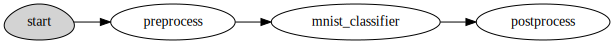

In [9]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Build the serving graph:
graph.to(handler="preprocess", name="preprocess")\
     .to(class_name=model_server_class, name="mnist_classifier", model_path=model_path)\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
graph.plot(rankdir='LR')

___
<a id="section_3"></a>

## 3. Test 

To test our serving function, we will create a mock server (simulator). Its like deploying the serving graph locally and this way we can debug more easily and quickly.

### 3.1. Create a Mock Server

We will create a mock server (simulator) using the function `to_mock_server()` and test the graph with the following image:

![](./mnist_digit.png)

In [10]:
# Create our server:
server = serving_function.to_mock_server()

> 2022-09-18 16:29:48,616 [info] model mnist_classifier was loaded


### 3.2. Run the Test

In order to send the image to the mock server, we will use the `server.test` method. This method expects two main arguments:
* `path` - Path to the method inside the `TFKerasModelServer`. We will be using the `predict` method.
* `body` - A JSON serializable input to send to our serving pipeline.

We will load our image and send it, expecting to get **5** with high confidence!

In [11]:
from PIL import Image

# Load our test image:
test_image = np.array(Image.open("./mnist_digit.png")).tolist()

# Infer thourgh the serving graph:
server.test(path='/predict', body={"inputs": test_image})

{'digit': 5, 'confidence': 0.9938642978668213}

___
<a id="section_4"></a>

## 4. Deploy

Now we will deploy a realtime serverless function. If you installed `ipycanvas` you can draw your own numbers and send them to the model.

### 4.1. Deploy a Realtime Serverless Function

Deploying is very easy, simply call the `deploy` method to deploy:

In [12]:
# Deploy:
serving_function.deploy()

> 2022-09-18 16:29:49,142 [info] Starting remote function deploy
2022-09-18 16:29:49  (info) Deploying function
2022-09-18 16:29:49  (info) Building
2022-09-18 16:29:50  (info) Staging files and preparing base images
2022-09-18 16:29:50  (info) Building processor image
2022-09-18 16:32:15  (info) Build complete
2022-09-18 16:32:35  (info) Function deploy complete
> 2022-09-18 16:32:36,333 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-mnist-classifier-guyl-mnist-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['mnist-classifier-guyl-mnist-serving-mnist-classifier-guyl.default-tenant.app.yh43.iguazio-cd1.com/']}


'http://mnist-classifier-guyl-mnist-serving-mnist-classifier-guyl.default-tenant.app.yh43.iguazio-cd1.com/'

### 4.2. Draw and Classify

In order to test our realtime serving function, we can use the method `invoke` which takes the same two argumetns as `test` of the mock server.

With `ipycanvas` we will create a canvas for drawing digits and send them to the model by running the code block after. 

In [ ]:
from ipywidgets import HBox, Button
from ipycanvas import Canvas, hold_canvas

# Create the canvas:
width = 200
height = 200
canvas = Canvas(width=width, height=height, sync_image_data=True)

# Define the 'on_mouse' actions functions to draw on the canvas:
is_drawing = False  # Whether to draw on the canvas.
position = None  # type: Tuple[float, float]  # Last known position holder.

def on_mouse_down(x, y):
    global is_drawing
    global position
    
    # Mark drawing should begin and store the first position:
    is_drawing = True
    position = (x, y)

def on_mouse_move(x, y):
    global is_drawing
    global position
    
    # If mouse is not down while moving (not drawing) return:
    if not is_drawing:
        return
    
    # Draw while saving the last position:
    with hold_canvas(canvas):
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)

def on_mouse_up(x, y):
    global is_drawing
    global position

    # Mark drawing has ended:
    is_drawing = False
    
    # Draw the last dot:
    canvas.stroke_line(position[0], position[1], x, y)

# Set the 'on_mouse' actions:
canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

# Configure the canvas style:
canvas.fill_style = "black"  # MNIST are with black background.
canvas.stroke_style = "white"  # MNIST digits are white.
canvas.line_width = 15
canvas.line_cap = 'round'
canvas.fill_rect(0, 0, width, height)

# Create the 'clear' button:
clear_button = Button(
    description='Clear',
    disabled=False,
    button_style='',
    tooltip='Clear the canvas drawings',
    icon='trash'
)

# Define the 'on_click' action function:
def on_click(button):
    canvas.fill_rect(0, 0, width, height)

# Set the 'on_click' action function:
clear_button.on_click(on_click)

# Present the canvas and the button on a horizontal layout:
HBox([canvas, clear_button])

In [ ]:
import numpy as np
from PIL import Image, ImageOps

# Get the image drawn from the canvas:
digit_image = canvas.get_image_data()

# Infer thourgh the realtime serving graph:
serving_function.invoke(path='/predict', body={"inputs": digit_image.tolist()})

___
**We hope you had fun MLRunning!**

If you have any comments, questions, suggestions, feel free to contact us at mlrun@iguazio.com!